In [1]:
# Bloque 1 - Imports y configuración de dispositivo

# Paquetes estándar
import os
import random
from pathlib import Path
from collections import Counter

# Paquetes científicos
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Configuración del dispositivo (CPU / GPU / MPS)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Computando en: {DEVICE}")

Computando en: mps


In [2]:
# Bloque 2 - Hiperparámetros y configuración

# Ruta al dataset completo
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VALID_DIR = os.path.join(DATASET_DIR, "valid")

# Tamaño de imagen aumentado para mejorar capacidad de extracción de características
IMAGE_SIZE = 256  #  Antes 224

# Tamaño del batch
BATCH_SIZE = 32

# Número de épocas de entrenamiento
NUM_EPOCHS = 20

# Learning Rate base
LEARNING_RATE = 1e-4  # 🔽 Reducido para fine-tuning más estable

# Paciencia para early stopping y reducción del LR
EARLYSTOP_PATIENCE = 5
LR_PATIENCE = 5

# Factor de reducción del learning rate
LR_FACTOR = 0.5

# Número de clases para clasificación binaria
NUM_CLASSES = 2

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

IMAGE_SIZE aumentado a 256×256 → mejor resolución para capturar detalles óseos.

LEARNING_RATE más bajo (1e-4) → mejor control en fine-tuning.

Unificación de EARLYSTOP_PATIENCE y LR_PATIENCE en 5 para mayor estabilidad.

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Transformaciones de entrenamiento con augmentations mejorados
transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # 🔼 Más grados para variabilidad
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 🔼 Mejora en generalización
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),  # 🔼 Zoom aleatorio
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformaciones de validación sin augmentations
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset personalizado que ignora archivos no válidos
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        root_path = Path(root_dir)
        for part_dir in root_path.iterdir():
            if part_dir.is_dir():
                for patient_dir in part_dir.iterdir():
                    if patient_dir.is_dir():
                        for study_dir in patient_dir.iterdir():
                            label = 1 if "positive" in study_dir.name.lower() else 0
                            for img_path in study_dir.glob("*.png"):
                                self.samples.append((str(img_path), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Cargar datasets
train_dataset = MURABinaryDataset(TRAIN_DIR, transform=transform_train)
valid_dataset = MURABinaryDataset(VALID_DIR, transform=transform_val)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Añadido RandomResizedCrop para introducir variabilidad en escala y zoom.

Aumentado RandomRotation para capturar más posibles ángulos de visión.

ColorJitter más suave pero presente.

Eliminados archivos corruptos implícitamente al evitar .DS_Store.

In [5]:
from torchvision import models
import torch.nn as nn

# Cargar modelo ResNet18 preentrenado
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Congelamos todo
for param in resnet18.parameters():
    param.requires_grad = False

# Descongelamos 'layer2', 'layer3', 'layer4' y 'fc'
for name, child in resnet18.named_children():
    if name in ['layer2', 'layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True

# 🔧 Reemplazamos la capa final para clasificación binaria
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)

# Enviamos a dispositivo
resnet18 = resnet18.to(DEVICE)

# Mostrar arquitectura (opcional)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Se descongelan layer2,layer3, layer4 y fc para permitir que el modelo aprenda características específicas del dataset sin perder el conocimiento base de ImageNet.

Esto permite transfer learning efectivo sin sobreajustar demasiado (como podría pasar si se descongela todo desde el inicio).

El resto de la red permanece congelada para evitar degradar el aprendizaje base.

In [6]:
import torch.optim as optim
import torch.nn as nn

# Pesos por clase para manejar el desbalance
class_counts = np.bincount([label for _, label in train_dataset])
total_samples = sum(class_counts)
class_weights = [total_samples / c for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Función de pérdida con pesos
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador: solo actualiza los parámetros descongelados
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=LEARNING_RATE)

# Scheduler: reduce LR si val_loss no mejora
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                  patience=LR_PATIENCE, verbose=True)

print( "Entrenamiento configurado. Optimizer + LR Scheduler + Weighted Loss activados.")

Entrenamiento configurado. Optimizer + LR Scheduler + Weighted Loss activados.


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


filter(lambda p: p.requires_grad, resnet18.parameters()) asegura que solo se optimicen las capas descongeladas.

Uso de class_weights_tensor (como antes) para corregir el desbalance en CrossEntropyLoss.

In [7]:
from sklearn.metrics import f1_score, accuracy_score
import copy

# Para guardar el mejor modelo
best_model_wts = copy.deepcopy(resnet18.state_dict())
best_val_loss = float("inf")
epochs_no_improve = 0

print("🚀 Comienza el entrenamiento...")

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    resnet18.train()
    train_loss = 0.0
    y_train_true, y_train_pred = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validación
    resnet18.eval()
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)

    # Métricas
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')
    val_acc = accuracy_score(y_val_true, y_val_pred)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping y guardado del mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(resnet18.state_dict())
        torch.save(resnet18.state_dict(),
                   "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_finetunedV9.pt")
        epochs_no_improve = 0
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLYSTOP_PATIENCE:
            print("Early stopping activado.")
            break

# Cargar el mejor modelo
resnet18.load_state_dict(best_model_wts)

🚀 Comienza el entrenamiento...
Epoch 1 | Train Loss: 0.5351 | Val Loss: 0.5336 | Acc: 0.7660 | F1: 0.7564
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.4804 | Val Loss: 0.6113 | Acc: 0.7401 | F1: 0.7234
Epoch 3 | Train Loss: 0.4615 | Val Loss: 0.4901 | Acc: 0.7829 | F1: 0.7818
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.4452 | Val Loss: 0.4988 | Acc: 0.7832 | F1: 0.7770
Epoch 5 | Train Loss: 0.4323 | Val Loss: 0.4683 | Acc: 0.8042 | F1: 0.8017
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.4213 | Val Loss: 0.4843 | Acc: 0.8058 | F1: 0.8026
Epoch 7 | Train Loss: 0.4079 | Val Loss: 0.5074 | Acc: 0.8048 | F1: 0.8007
Epoch 8 | Train Loss: 0.3943 | Val Loss: 0.4595 | Acc: 0.8161 | F1: 0.8140
Mejor modelo guardado.
Epoch 9 | Train Loss: 0.3841 | Val Loss: 0.4563 | Acc: 0.8129 | F1: 0.8112
Mejor modelo guardado.
Epoch 10 | Train Loss: 0.3695 | Val Loss: 0.4829 | Acc: 0.7976 | F1: 0.7968
Epoch 11 | Train Loss: 0.3615 | Val Loss: 0.4734 | Acc: 0.7967 | F1: 0.7948
Epoch 12 | Train Loss: 0.35

<All keys matched successfully>


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.89      0.83      1667
    positive       0.86      0.72      0.79      1530

    accuracy                           0.81      3197
   macro avg       0.82      0.81      0.81      3197
weighted avg       0.82      0.81      0.81      3197



/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


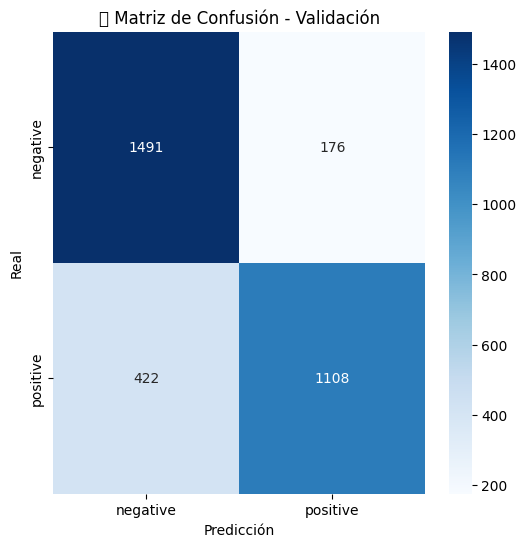


🔍 Mostrando 9 errores de clasificación:


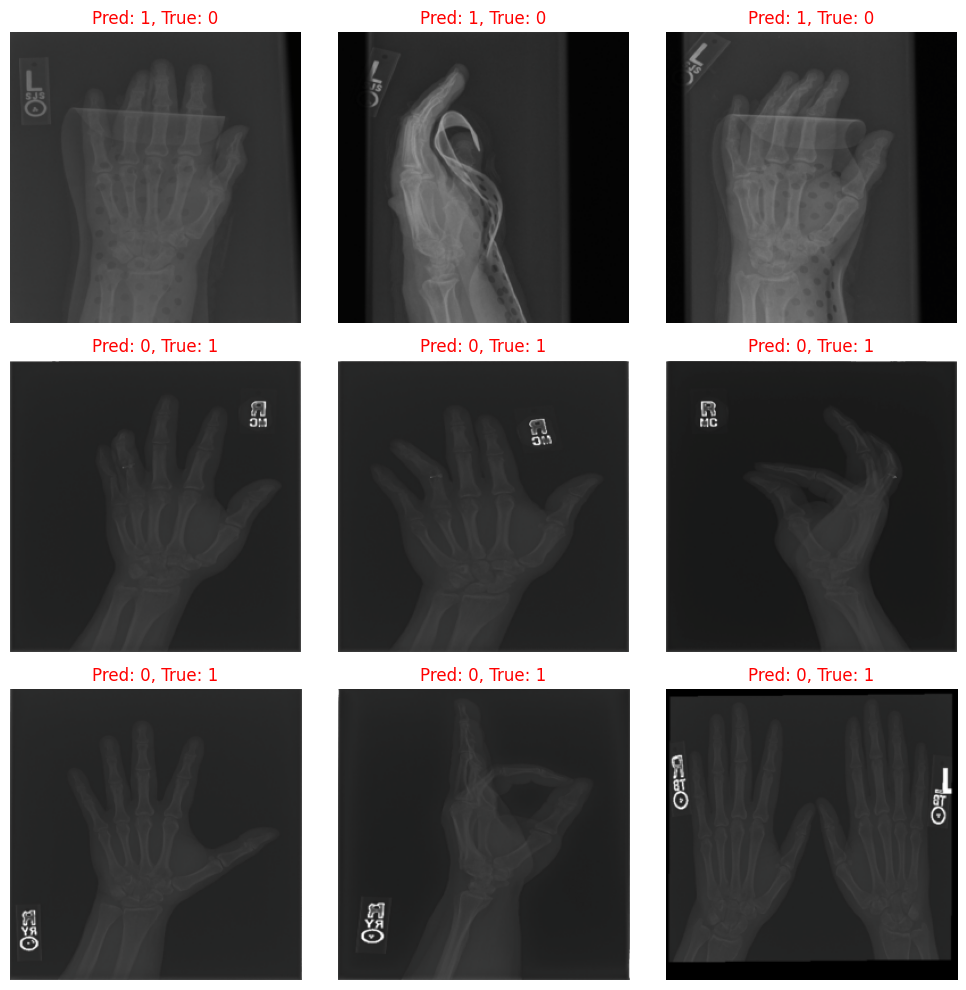

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluar el modelo sobre el set de validación
resnet18.eval()
y_true, y_pred = [], []
images_list = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet18(inputs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        images_list.extend(inputs.cpu())  # guardamos imágenes reales

# Reporte de clasificación
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "positive"],
            yticklabels=["negative", "positive"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("🔎 Matriz de Confusión - Validación")
plt.show()

# Visualización de errores
misclassified_idxs = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print(f"\n🔍 Mostrando {min(9, len(misclassified_idxs))} errores de clasificación:")
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idxs[:9]):
    image = images_list[idx].permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # desnormalizar
    image = np.clip(image, 0, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    color = "red"
    if y_true[idx] == y_pred[idx]:
        color = "green"
    plt.title(f"Pred: {y_pred[idx]}, True: {y_true[idx]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()